In [1]:
! if [ ! $pip_done ]; then pip install -q transformers ;fi 
! if [ ! $pip_done ]; then pip install -q datasets jiwer ;fi 
! if [ ! $pip_done ]; then pip install -q sentencepiece ;fi 

pip_done = 1

In [2]:
!git clone https://github.com/OmarMoMorgan/Arabic_scene_text.git

Cloning into 'Arabic_scene_text'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 73 (delta 26), reused 62 (delta 16), pack-reused 0
Unpacking objects: 100% (73/73), 30.52 KiB | 1.45 MiB/s, done.


In [3]:
import torch
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, AdamW
from sklearn.model_selection import train_test_split
from torch import nn , optim


import sys
sys.path.append('/kaggle/working/Arabic_scene_text') #change this to the name of the repo
from models import build_model , KAN
from tools import EarlyStopping, tune_model , generate_text_with_caption , validate_epoch
from data import train_test_split_ , perPixel_mean_std, perChannel_mean_std, build_transforms

/kaggle/working/Arabic_scene_text/tools/trainer.py:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [4]:
root_dir = "/kaggle/input/str-arabic-dataset/Arabic_words_train"
column_names = ['image_path', 'text']
df = pd.read_csv("/kaggle/input/str-arabic-dataset/Arabic_words_train/gt.txt",nrows = 4187 , names = column_names)


test_size = 0.2
train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)

test_df , val_df = train_test_split(test_df, test_size=0.5, random_state=42)



In [5]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [6]:
train_df.shape, val_df,test_df.shape

((3349, 2),
         image_path    text
 0    word_2789.png     فقط
 1    word_1378.png   مجتمع
 2    word_3810.png    خروج
 3    word_2529.png    كلية
 4    word_2974.png    راحة
 ..             ...     ...
 414   word_354.png  إنتظار
 415  word_2328.png     على
 416  word_2902.png    توجد
 417   word_817.png     مصر
 418  word_3438.png     سيد
 
 [419 rows x 2 columns],
 (419, 2))

Making the data loader here 

In [7]:
class ArabicSTRDataset(Dataset):
    def __init__(self, root_dir, df, processor, tokenizer, max_target_length):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.tokenizer = tokenizer
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get file name and text
        file_name = self.df.iloc[idx]['image_path']
        text = self.df.iloc[idx]['text']

        # Prepare image (resize and normalize)
        image_path = f"{self.root_dir}/{file_name}"
        image = Image.open(image_path).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        # Encode the text
        labels = self.tokenizer(text, padding="max_length", max_length=self.max_target_length, return_tensors="pt").input_ids
        labels = labels.squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100


        encoding = {"pixel_values": pixel_values.squeeze(), "labels": labels}
        return encoding

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Making the pretrained model using gpt 2 as tokenizer and processor and for the backbone of the network we are using vision transormer with Deit archietcures and pretrained weights 

In [9]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1")
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-stage1')
tokenizer_ = processor.tokenizer
model.to(device)

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-05-22 11:48:31.306374: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 11:48:31.306478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 11:48:31.424816: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

Paramters set for processor 

In [10]:
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 512
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

batch_size = 8

In [11]:
train_dataset = ArabicSTRDataset(root_dir=root_dir,
                           df=train_df,
                           processor=processor,
                           tokenizer=processor.tokenizer,
                           max_target_length=100)

eval_dataset = ArabicSTRDataset(root_dir=root_dir,
                           df=val_df,
                           processor=processor,
                           tokenizer=processor.tokenizer,
                           max_target_length=100)

test_dataset = ArabicSTRDataset(root_dir=root_dir,
                           df=test_df,
                           processor=processor,
                           tokenizer=processor.tokenizer,
                           max_target_length=100)

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [13]:
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',patience = 5,factor = 0.1,verbose=True)
earlystopping = EarlyStopping()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
hist_ = tune_model(35,model,train_dataloader,eval_dataloader,\
               optimizer,device,tokenizer_ , scheduler,earlystopping=earlystopping)

  0%|          | 0/419 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1197: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

For epoch   4 || Training Loss 1.429 || acc 0.628 || Testing Loss 1.291 || Test acc 0.615


  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

For epoch   9 || Training Loss 0.316 || acc 0.107 || Testing Loss 0.661 || Test acc 0.240


  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

For epoch  14 || Training Loss 0.158 || acc 0.041 || Testing Loss 0.642 || Test acc 0.242


  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Early Stopping Activated


In [15]:
#!rm -rf /kaggle/working/*

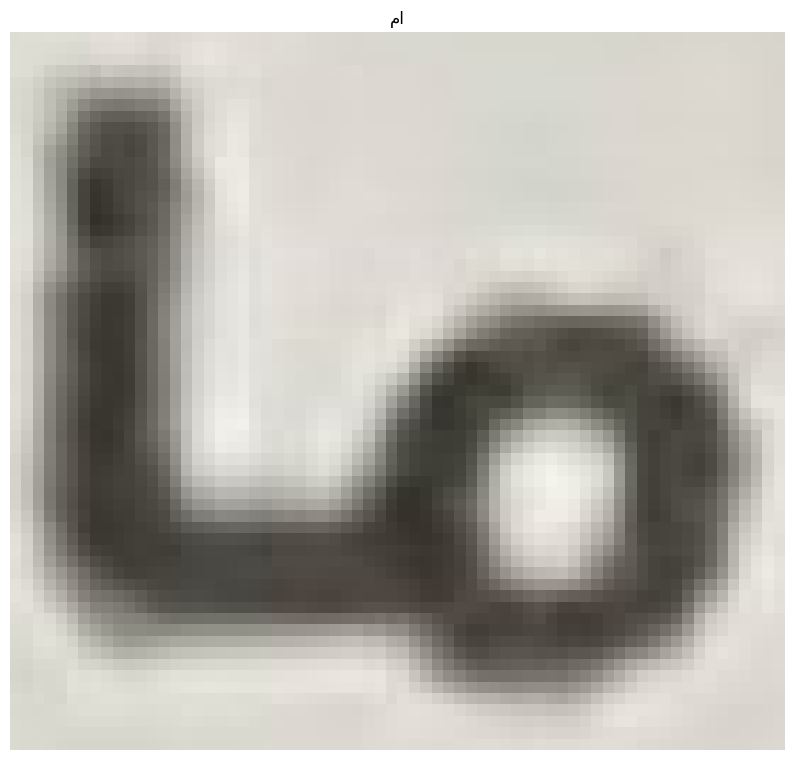

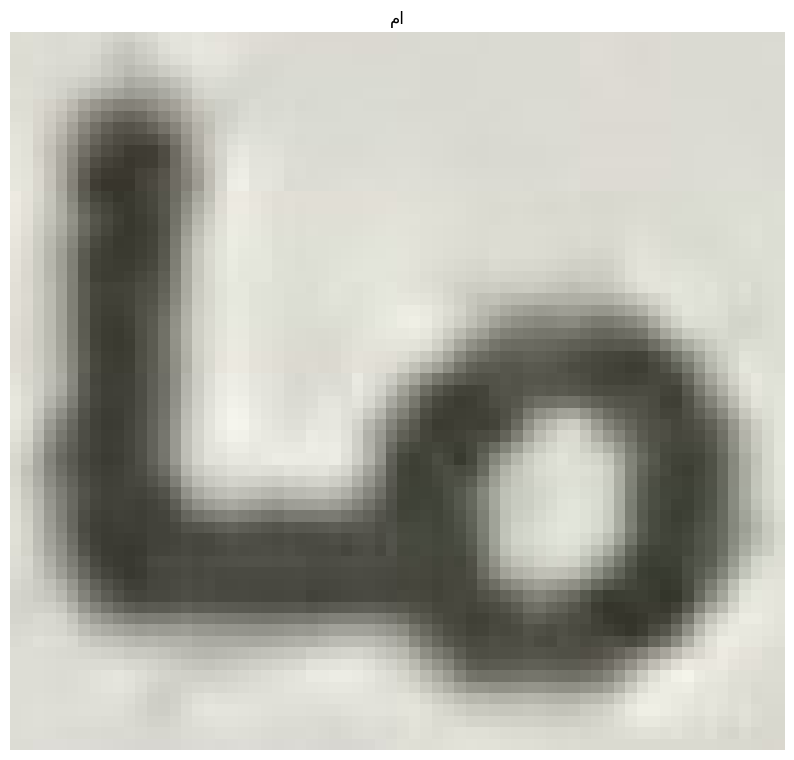

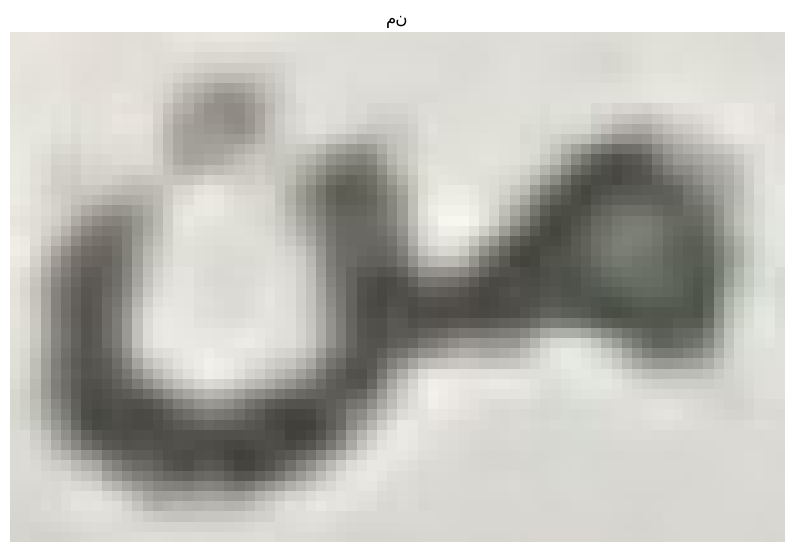

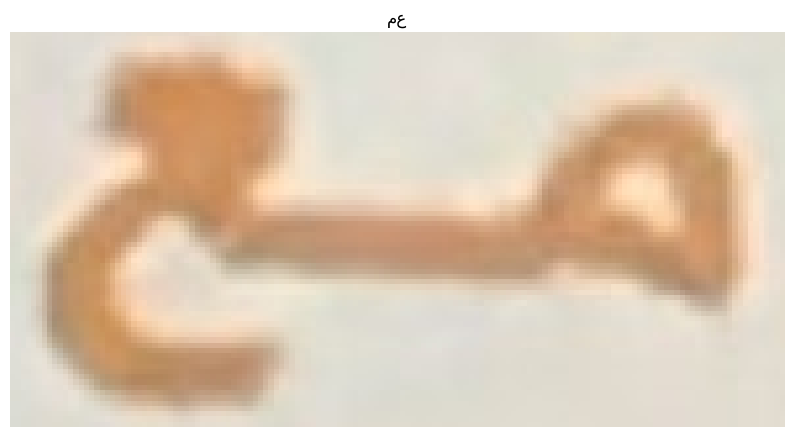

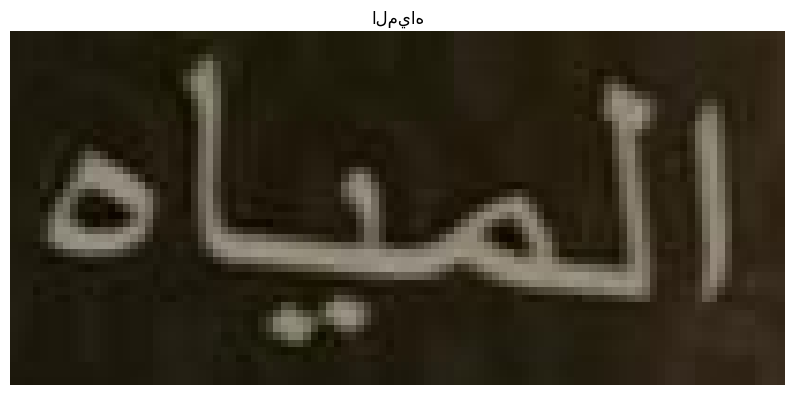

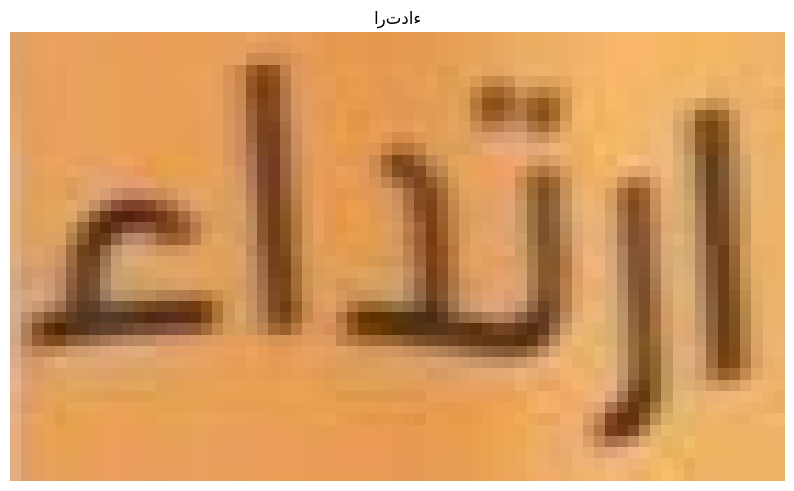

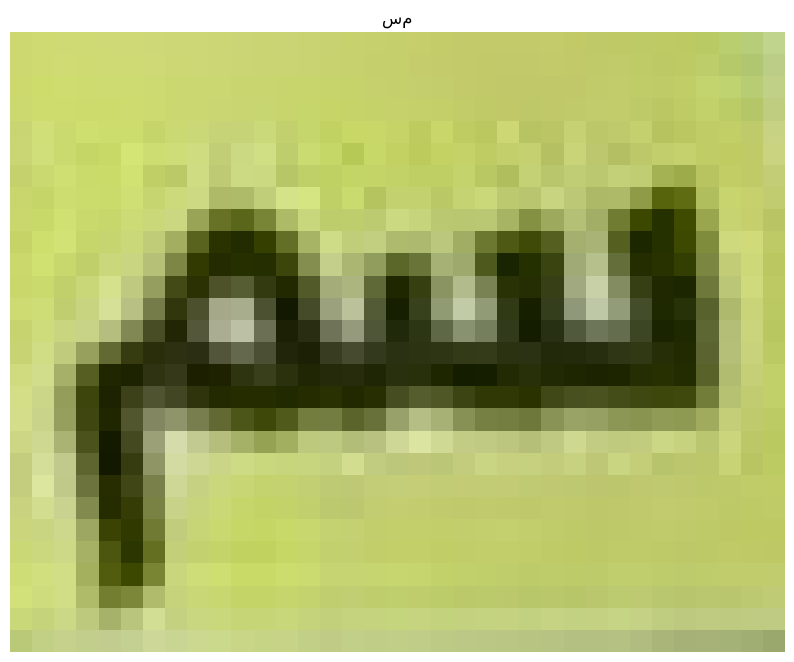

'سم'

In [16]:
generate_text_with_caption('/kaggle/input/str-arabic-dataset/Arabic_words_train/word_1011.png',processor,device,model)
generate_text_with_caption('/kaggle/input/str-arabic-dataset/Arabic_words_train/word_1013.png',processor,device,model)
generate_text_with_caption('/kaggle/input/str-arabic-dataset/Arabic_words_train/word_1017.png',processor,device,model)
generate_text_with_caption('/kaggle/input/str-arabic-dataset/Arabic_words_train/word_1019.png',processor,device,model)
generate_text_with_caption('/kaggle/input/str-arabic-dataset/Arabic_words_train/word_4011.png',processor,device,model)
generate_text_with_caption('/kaggle/input/str-arabic-dataset/Arabic_words_train/word_2211.png',processor,device,model)
generate_text_with_caption('/kaggle/input/str-arabic-dataset/Arabic_words_train/word_3311.png',processor,device,model)


In [17]:
lss_test, CER_test = validate_epoch(model,test_dataloader,optimizer,device,tokenizer_)
print('lss for test dataset is: ' , lss_test , 'CER is' , CER_test)

  0%|          | 0/53 [00:00<?, ?it/s]

lss for test dataset is:  0.597918044143128 CER is 0.20863429189662205
